In [53]:
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../../'))
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wave
import torch
from Audio_Sentiment_Analysis.utils.vscode_audio import Audio
torch.set_num_threads(1)
from sklearn import preprocessing

AUDIO_DIR = f"{os.path.abspath('./../../../')}/IEMOCAP_Dataset"

plt.rcParams['figure.dpi'] = 300

# Loading File from IEMOCAP

Sample Rate: 16000 Hz


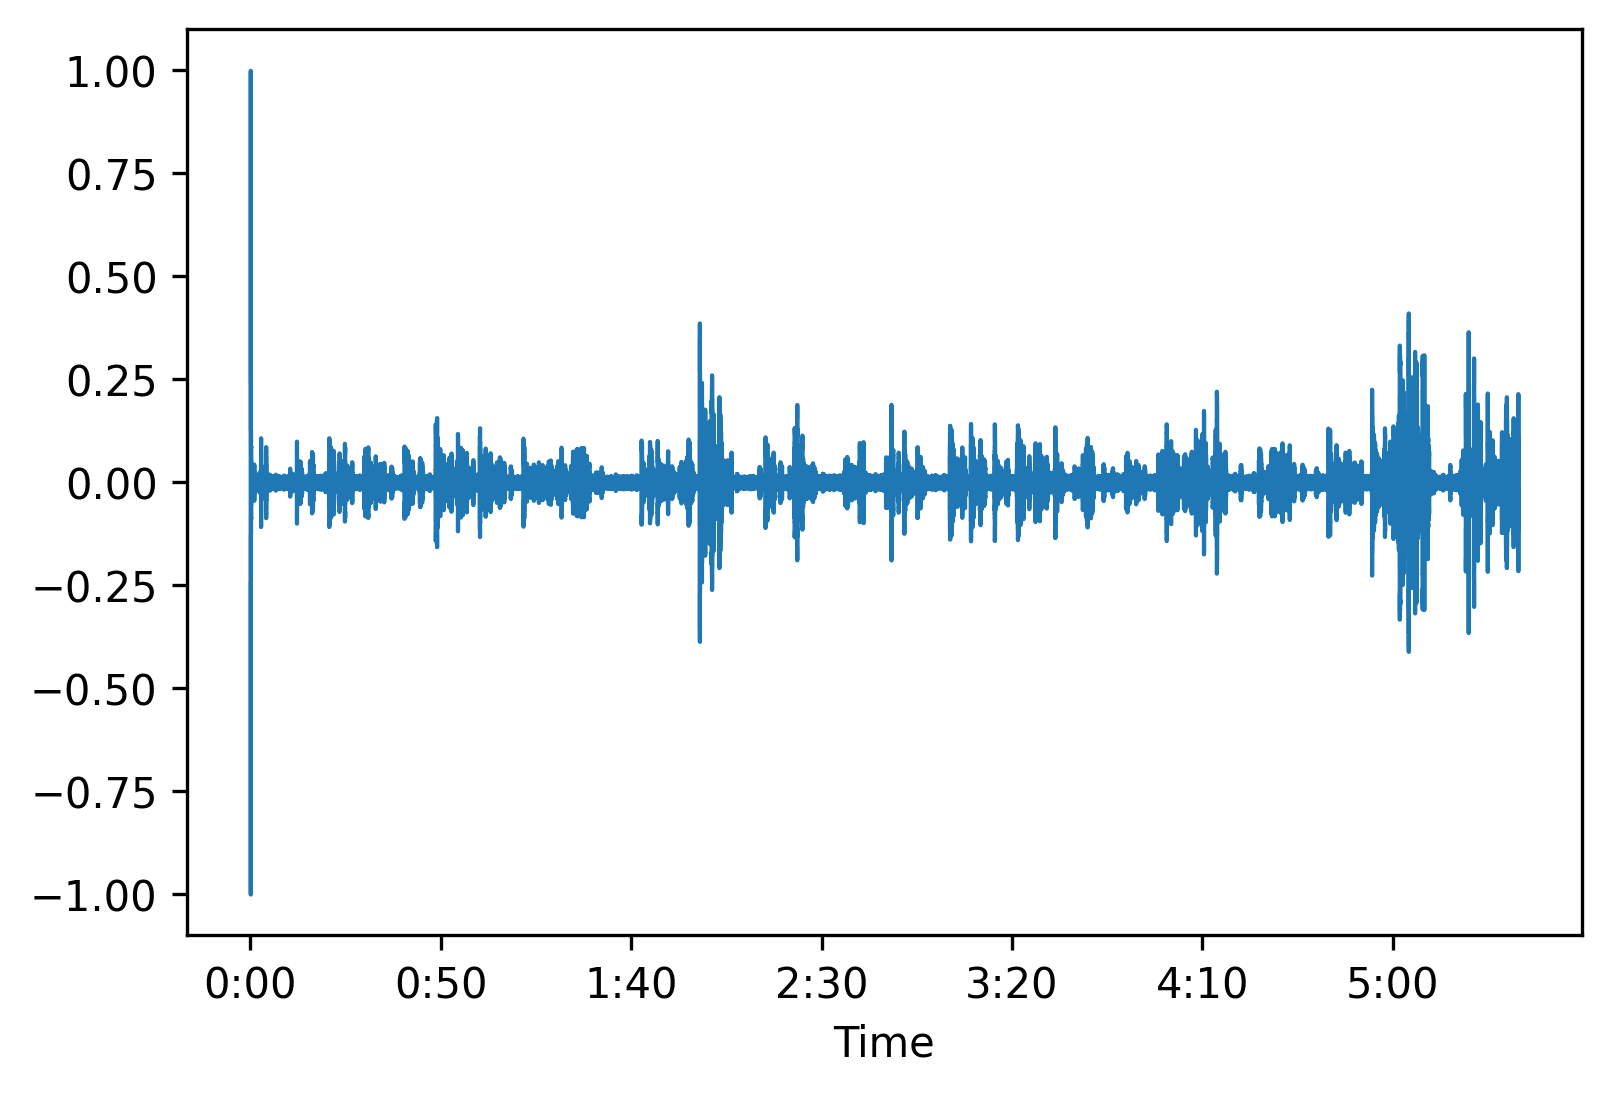

In [54]:
audio_file_test = AUDIO_DIR+'/Session1/dialog/wav/Ses01F_impro06.wav'
y, sr = librosa.load(audio_file_test, sr=16000)
y_to_print = preprocessing.minmax_scale(y, feature_range=(-1, 1))
librosa.display.waveshow(y_to_print, sr=sr)
print(f"Sample Rate: {sr} Hz")
plt.show()

In [55]:
all_voiced_frames = []
male_voiced_frames = []
female_voiced_frames = []
with open(AUDIO_DIR+'/Session1/dialog/EmoEvaluation/Ses01F_impro06.txt') as emotions_test_file:
    for line in emotions_test_file:
        if line[0] == '[':
            args = line.split()
            if 'M' == args[3][-4]:
                male_voiced_frames.append((float(args[0][1:]), float(args[2][:-1])))
            else:
                female_voiced_frames.append((float(args[0][1:]), float(args[2][:-1])))
            all_voiced_frames.append((float(args[0][1:]), float(args[2][:-1])))
all_voiced_frames.sort(key=lambda x: x[0])

In [56]:
# These have both female and male actors speech times
print(f"Number of separate actors voice frames: {len(all_voiced_frames)}")
print(all_voiced_frames)

Number of separate actors voice frames: 47
[(11.46, 14.74), (14.7939, 18.17), (18.49, 24.91), (24.02, 25.69), (25.12, 26.56), (26.07, 27.65), (28.97, 35.02), (34.45, 35.78), (36.07, 38.04), (39.6025, 46.29), (47.34, 59.38), (56.17, 57.49), (59.4525, 67.4525), (70.22, 80.13), (80.16, 87.74), (86.96, 88.63), (87.83, 93.67), (101.83, 116.91), (107.78, 109.27), (117.07, 126.04), (125.47, 127.19), (132.9575, 134.49), (134.4, 136.49), (135.96, 137.95), (137.09, 138.44), (138.0685, 141.05), (141.84, 149.4375), (144.09, 145.68), (155.07, 158.38), (158.08, 163.35), (165.61, 168.1), (167.64, 174.84), (174.39, 177.15), (176.35, 178.01), (182.56, 197.73), (197.755, 214.34), (217.5, 222.41), (219.73, 221.03), (223.52, 227.55), (229.08, 235.98), (237.53, 256.48), (255.35, 257.31), (262.99, 266.175), (266.55, 275.31), (275.38, 281.6), (282.01, 311.14), (308.24, 310.01)]


In [57]:
# Here we have both female and male actors speech times combined
# while not allowing differences between frames to be inferior than 1 second
min_frame_duration = 1 # duration in seconds

combined_voiced_frames = []
prev_start, prev_end = all_voiced_frames[0]
for start, end in all_voiced_frames[1:]:
    if start - prev_end <= min_frame_duration:
        prev_end = end
    else:
        combined_voiced_frames.append((prev_start, prev_end))
        prev_start, prev_end = start, end
combined_voiced_frames.append((prev_start, prev_end))
combined_voiced_frames.sort(key=lambda x: x[0])
processed_combined_voiced_frames = []
for x in combined_voiced_frames:
    while ((x[1] - x[0]) > 6):
        processed_combined_voiced_frames.append((x[0], x[0]+6))
        x = (x[0]+6, x[1])
    if (x[1] - x[0]) >= 1:
        processed_combined_voiced_frames.append(x)
print(f"Number of combined actors voice frames: {len(processed_combined_voiced_frames)}")
print(processed_combined_voiced_frames)

Number of combined actors voice frames: 45
[(11.46, 17.46), (17.46, 23.46), (23.46, 27.65), (28.97, 34.97), (34.97, 38.04), (39.6025, 45.6025), (47.34, 53.34), (53.34, 57.49), (59.4525, 65.4525), (65.4525, 67.4525), (70.22, 76.22), (76.22, 82.22), (82.22, 88.22), (88.22, 93.67), (101.83, 107.83), (107.83, 109.27), (117.07, 123.07), (123.07, 127.19), (132.9575, 138.9575), (138.9575, 144.9575), (155.07, 161.07), (161.07, 163.35), (165.61, 171.61), (171.61, 177.61), (182.56, 188.56), (188.56, 194.56), (194.56, 200.56), (200.56, 206.56), (206.56, 212.56), (212.56, 214.34), (217.5, 221.03), (223.52, 227.55), (229.08, 235.08), (237.53, 243.53), (243.53, 249.53), (249.53, 255.53), (255.53, 257.31), (262.99, 268.99), (268.99, 274.99), (274.99, 280.99), (280.99, 286.99), (286.99, 292.99), (292.99, 298.99), (298.99, 304.99), (304.99, 310.01)]


# File Voiced Frames

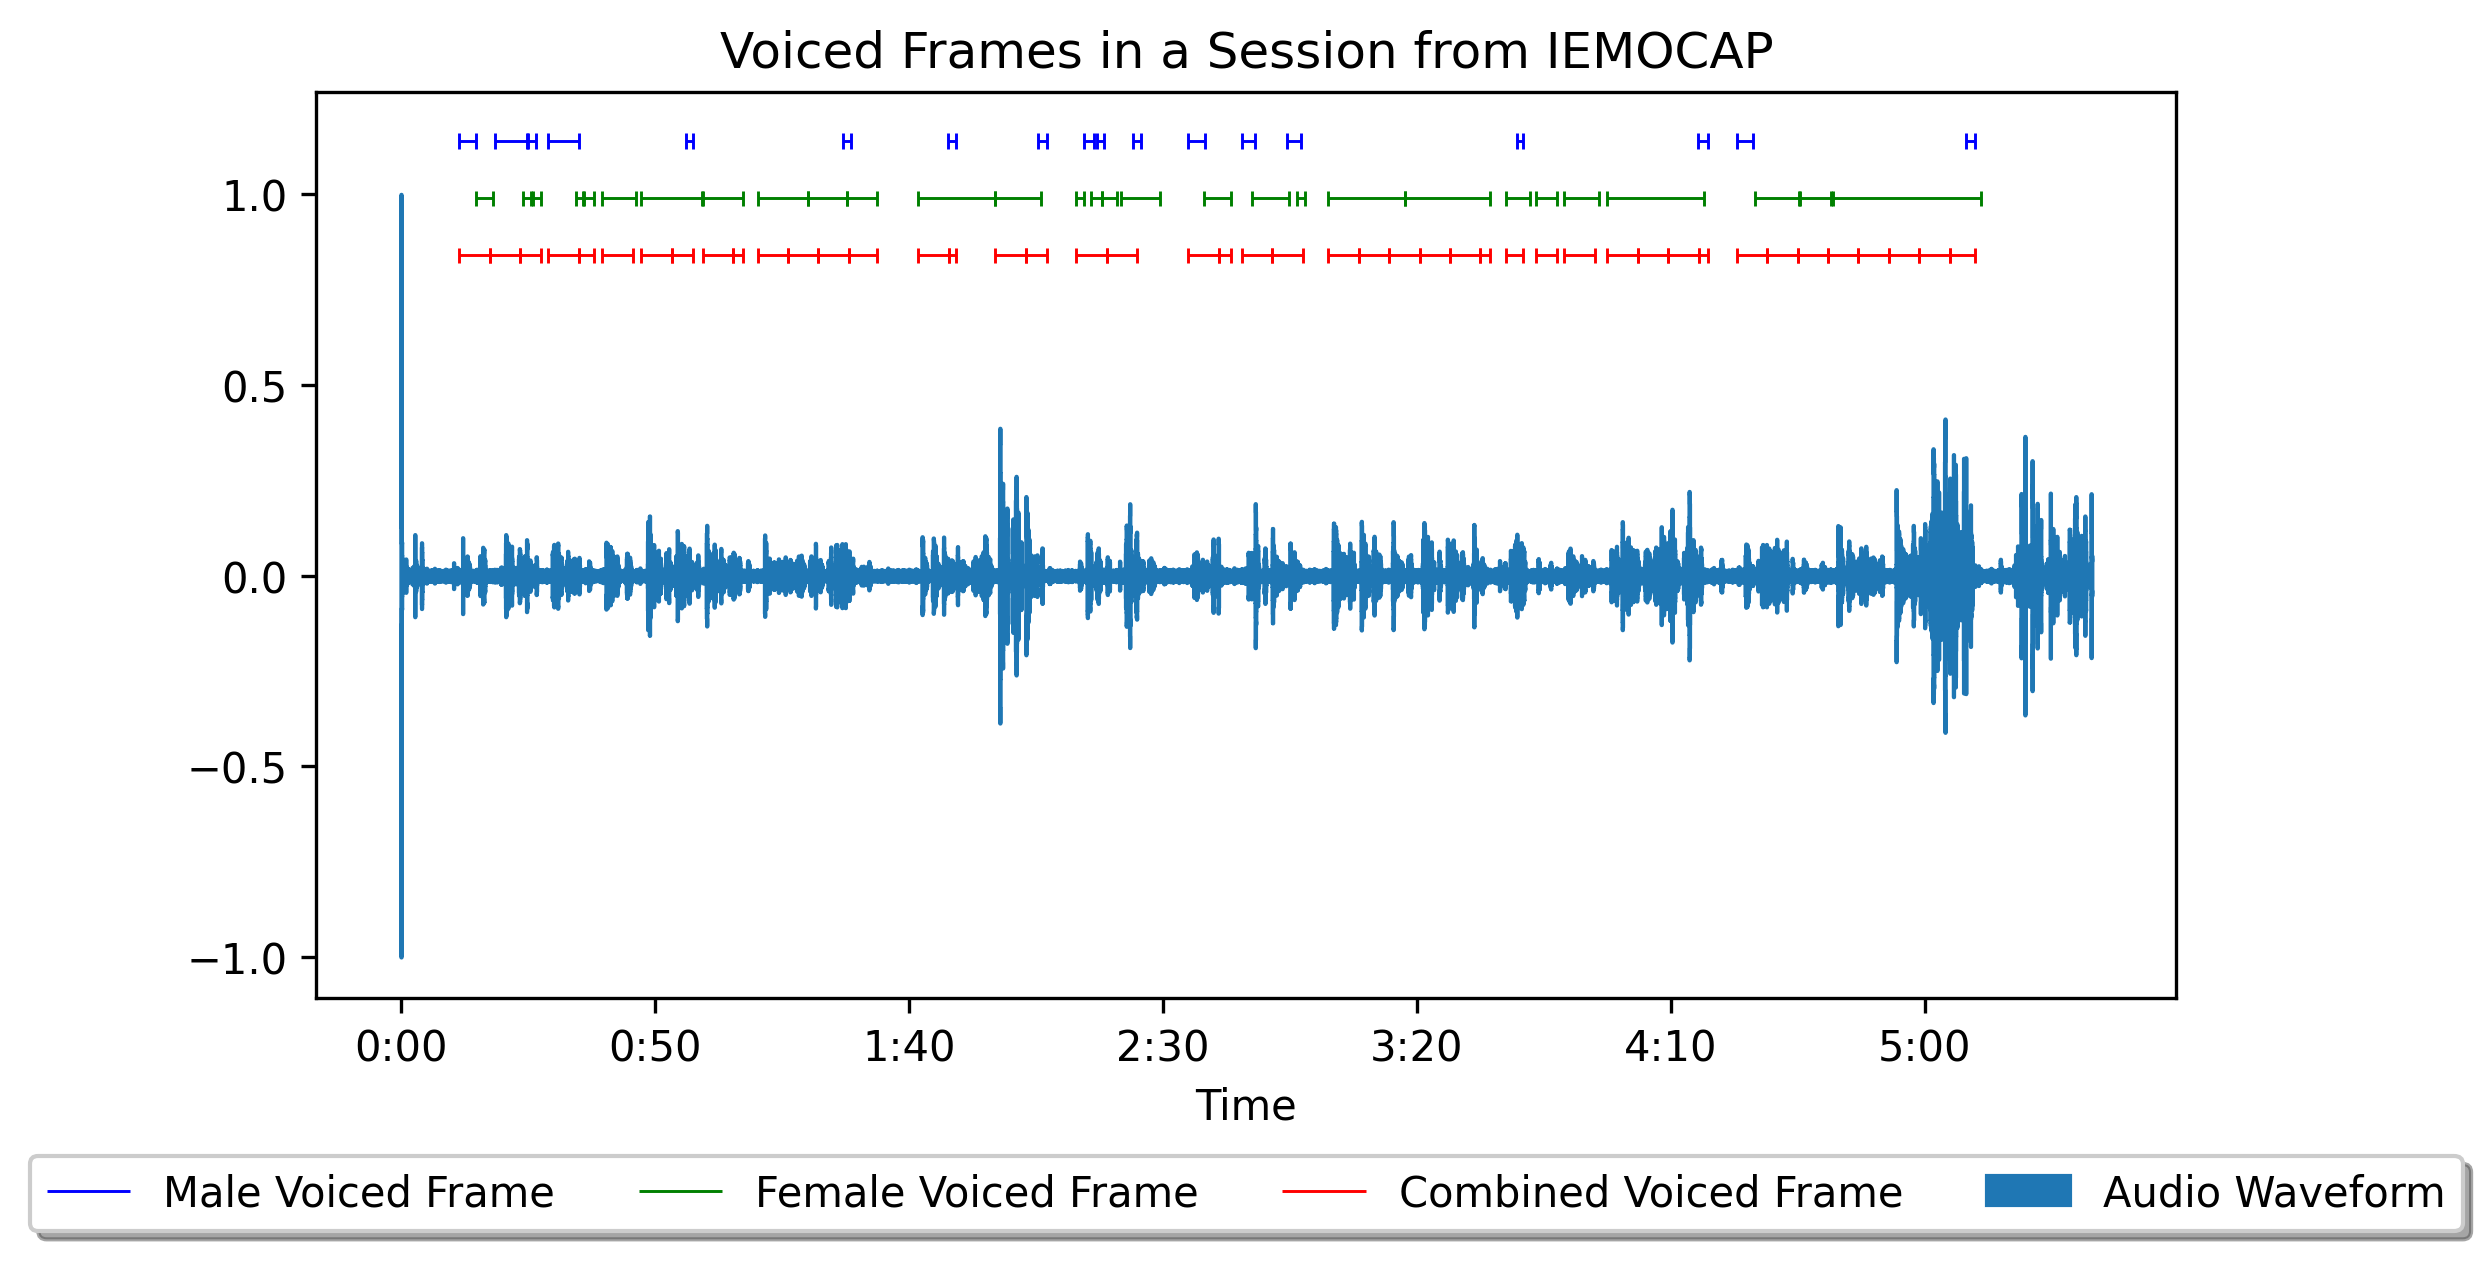

In [58]:
plt.figure(figsize=(8, 4))
plt.title("Voiced Frames in a Session from IEMOCAP")

y_len = np.max(y_to_print) * 0.02
y_space = np.max(y_to_print) * 0.1
upper_y, middle_y, lower_y = np.max(y_to_print)+ y_space + y_len*3, np.max(y_to_print)+ y_space + y_len*2, np.max(y_to_print)+ y_space + y_len

upper_y, middle_y, lower_y = upper_y, middle_y, lower_y
start, end = male_voiced_frames[0]
plt.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='blue', label="Male Voiced Frame")
plt.vlines(start, color='blue', linewidth=.7, ymin=upper_y, ymax=lower_y)
plt.vlines(end, color='blue', linewidth=.7, ymin=upper_y, ymax=lower_y)
for start, end in male_voiced_frames[1:]:
    plt.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='blue')
    plt.vlines(start, color='blue', linewidth=.7, ymin=upper_y, ymax=lower_y)
    plt.vlines(end, color='blue', linewidth=.7, ymin=upper_y, ymax=lower_y)

upper_y, middle_y, lower_y = upper_y - 0.15, middle_y - 0.15, lower_y - 0.15
start, end = female_voiced_frames[0]
plt.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='green', label="Female Voiced Frame")
plt.vlines(start, color='green', linewidth=.7, ymin=upper_y, ymax=lower_y)
plt.vlines(end, color='green', linewidth=.7, ymin=upper_y, ymax=lower_y)
for start, end in female_voiced_frames[1:]:
    plt.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='green')
    plt.vlines(start, color='green', linewidth=.7, ymin=upper_y, ymax=lower_y)
    plt.vlines(end, color='green', linewidth=.7, ymin=upper_y, ymax=lower_y)

upper_y, middle_y, lower_y = upper_y - 0.15, middle_y - 0.15, lower_y - 0.15
start, end = processed_combined_voiced_frames[0]
plt.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='red', label="Combined Voiced Frame")
plt.vlines(start, color='red', linewidth=.7, ymin=upper_y, ymax=lower_y)
plt.vlines(end, color='red', linewidth=.7, ymin=upper_y, ymax=lower_y)
for start, end in processed_combined_voiced_frames[1:]:
    plt.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='red')
    plt.vlines(start, color='red', linewidth=.7, ymin=upper_y, ymax=lower_y)
    plt.vlines(end, color='red', linewidth=.7, ymin=upper_y, ymax=lower_y)

librosa.display.waveshow(y_to_print, sr=sr, label="Audio Waveform")

plt.legend(loc='lower center', bbox_to_anchor=(.5, -.28),
        ncol=4, fancybox=True, shadow=True)
plt.show()

# Speech Segmentation with SileroVAD

In [59]:
def read_wav_part_from_local(path: str, sr: float, start_s: float, duration_s: float):
    with wave.open(path, mode='rb') as wavread:
        start = int(start_s * sr)
        duration = int(duration_s * sr)
        wavread.setpos(start)
        return wavread.readframes(duration)

def process_bytes(y, FORMAT):
    y = np.frombuffer(y, FORMAT)
    if FORMAT == np.int32:
        abs_max = np.abs(y).max()
        y = y.astype('float32')
        if abs_max > 0:
            y *= 1/abs_max
        y = y.squeeze()
    elif FORMAT != np.float32:
        y = y.astype('float32')
    return y

def normalize_audio(y, sr):
    if sr != 16000:
        y = librosa.resample(y, sr, 16000)
    if NO_CHANNELS != 1:
        y = librosa.to_mono(y)
    return y

vad_model, _ = torch.hub.load(
    repo_or_dir='snakers4/silero-vad',
    model='silero_vad',
    force_reload=False
)

FORMAT=np.int32
SAMPLE_RATE=16000
NO_CHANNELS=1
MIN_CONFIDENCE=0.5
MIN_DURATION=1
MAX_DURATION=6
STEP = 1

silero_voiced_frames = []
silero_confidences = []
current_y, prev_start, prev_end = None, None, None
for start in np.arange(0, librosa.get_duration(y=y, sr=SAMPLE_RATE), STEP):
    wav = read_wav_part_from_local(audio_file_test, SAMPLE_RATE, start, STEP)
    wav = process_bytes(wav, FORMAT)
    wav = normalize_audio(wav, SAMPLE_RATE)

    confidence = vad_model(torch.from_numpy(wav), SAMPLE_RATE).item()
    silero_confidences.append(confidence)

    end = start + STEP
    if confidence >= MIN_CONFIDENCE:
        if prev_end == None:
            current_y = wav
            prev_start, prev_end = start, end
        else:
            current_y = np.append(current_y, wav)
            prev_end = end
            if (end - prev_start) >= MAX_DURATION:
                silero_voiced_frames.append((prev_start, prev_end))
                prev_start, prev_end, current_y = None, None, None
    elif prev_end:
        if (prev_end - prev_start) >= MIN_DURATION:
            silero_voiced_frames.append((prev_start, prev_end))
        prev_start, prev_end, current_y = None, None, None

if (len(silero_voiced_frames) and silero_voiced_frames[-1] != (prev_start, prev_end) and prev_end) or ((not len(silero_voiced_frames)) and prev_end):
    if (prev_end - prev_start) > MIN_DURATION:
        silero_voiced_frames.append((prev_start, prev_end))

Using cache found in C:\Users\Chico/.cache\torch\hub\snakers4_silero-vad_master


# Pipeline Results

In [60]:
pd.DataFrame([y - x for x,y in silero_voiced_frames], columns=['Voice Frames']).describe()

,Voice Frames
count,51.000000
mean,3.588235
std,2.060839
min,1.000000
25%,2.000000
50%,4.000000
75%,6.000000
max,6.000000


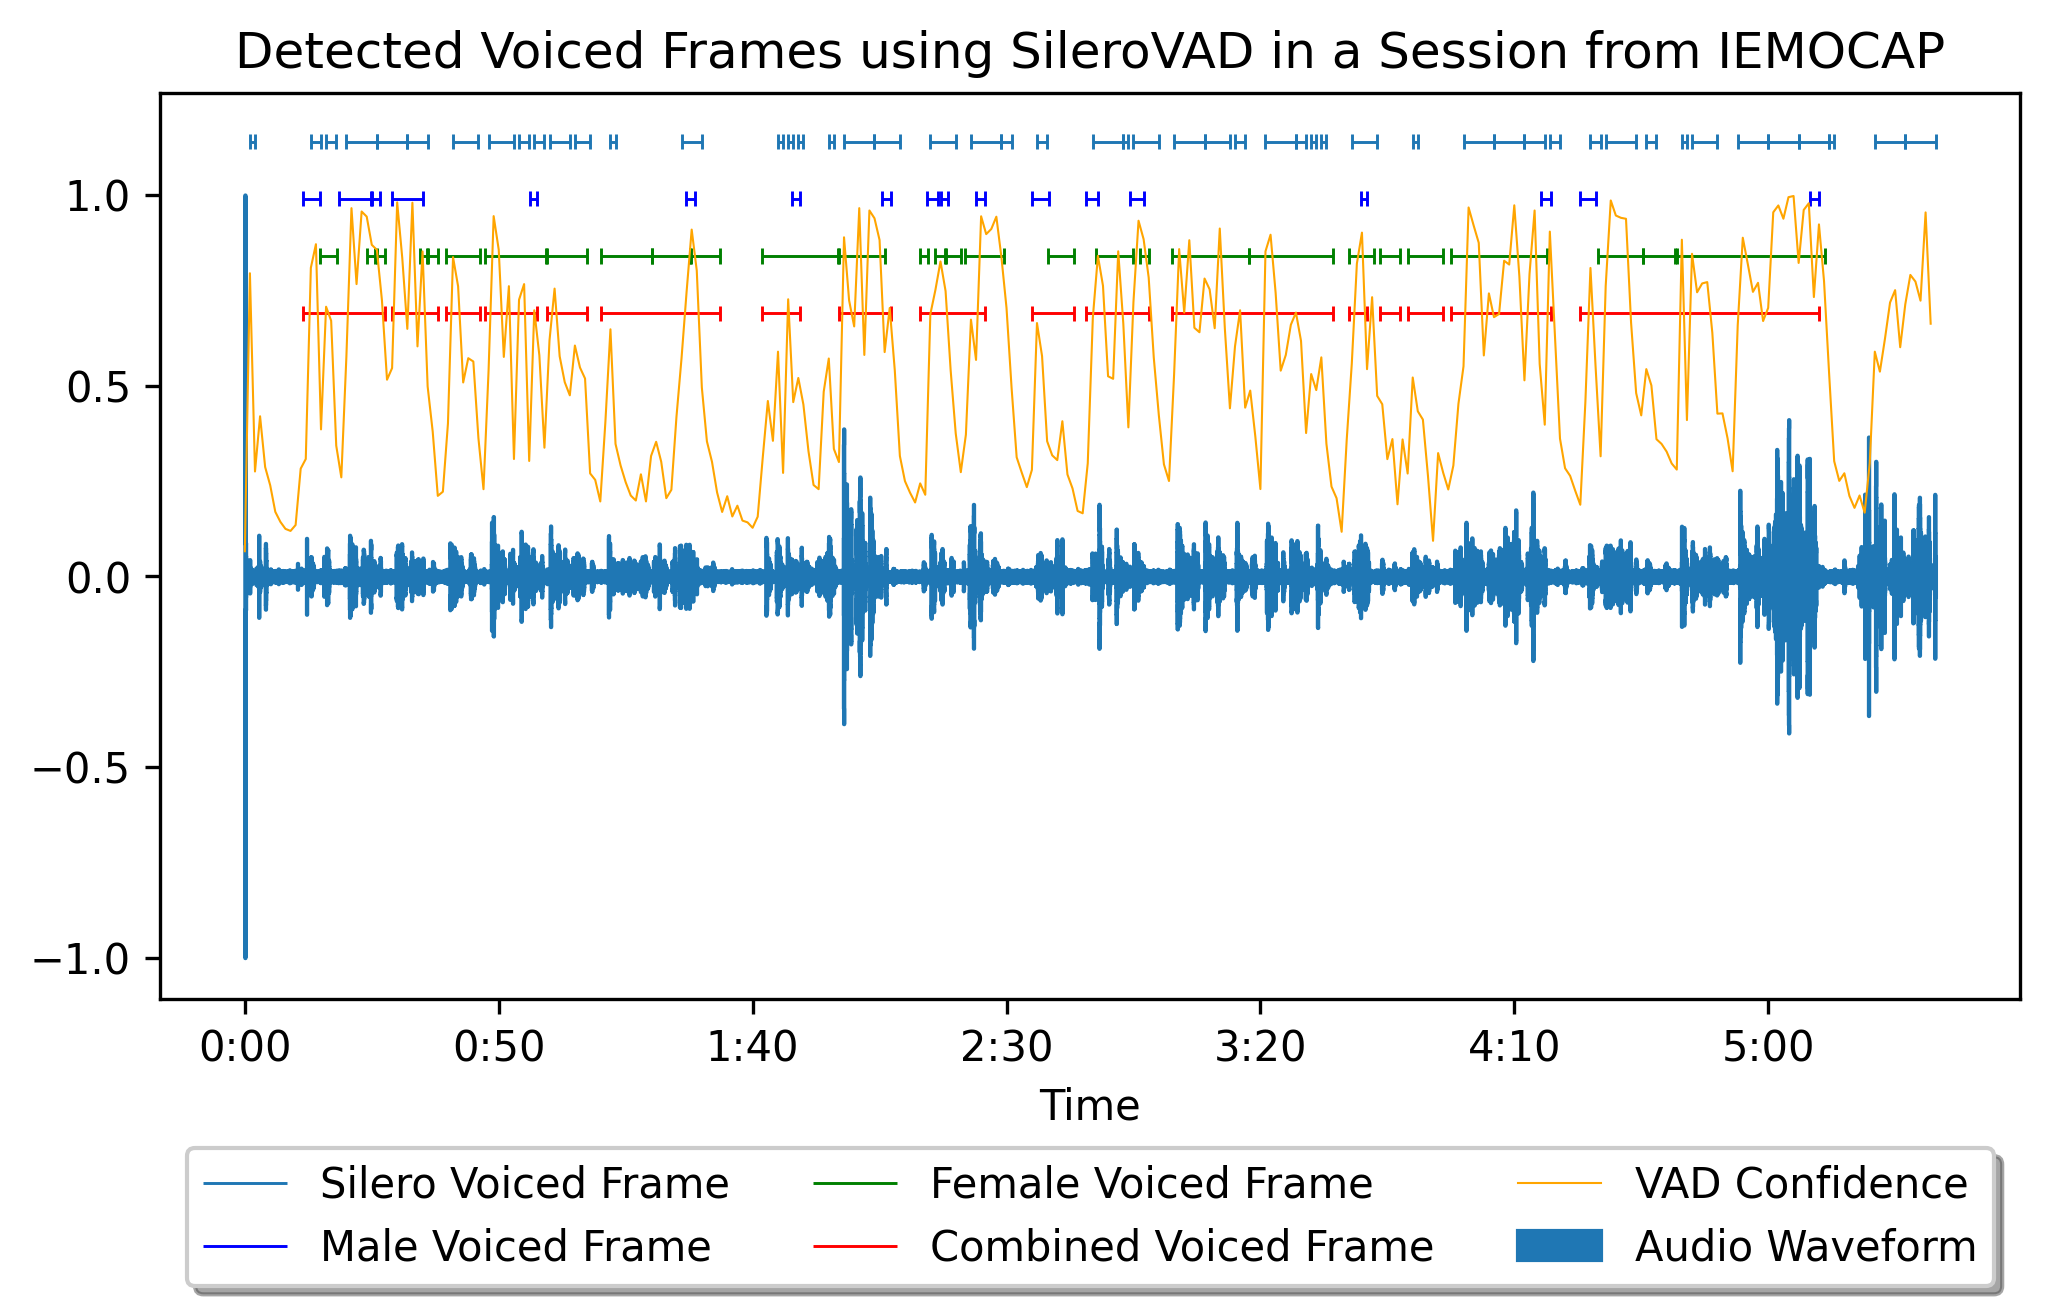

In [66]:
plt.figure(figsize=(8, 4))
plt.title("Detected Voiced Frames using SileroVAD in a Session from IEMOCAP")

y_len = np.max(y_to_print) * 0.02
y_space = np.max(y_to_print) * 0.1
upper_y, middle_y, lower_y = np.max(y_to_print)+ y_space + y_len*3, np.max(y_to_print)+ y_space + y_len*2, np.max(y_to_print)+ y_space + y_len

upper_y, middle_y, lower_y = upper_y, middle_y, lower_y
start, end = silero_voiced_frames[0]
plt.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='tab:blue', label="Silero Voiced Frame")
plt.vlines(start, color='tab:blue', linewidth=.7, ymin=upper_y, ymax=lower_y)
plt.vlines(end, color='tab:blue', linewidth=.7, ymin=upper_y, ymax=lower_y)
for start, end in silero_voiced_frames[1:]:
    plt.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='tab:blue')
    plt.vlines(start, color='tab:blue', linewidth=.7, ymin=upper_y, ymax=lower_y)
    plt.vlines(end, color='tab:blue', linewidth=.7, ymin=upper_y, ymax=lower_y)


upper_y, middle_y, lower_y = upper_y - 0.15, middle_y - 0.15, lower_y - 0.15
start, end = male_voiced_frames[0]
plt.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='blue', label="Male Voiced Frame")
plt.vlines(start, color='blue', linewidth=.7, ymin=upper_y, ymax=lower_y)
plt.vlines(end, color='blue', linewidth=.7, ymin=upper_y, ymax=lower_y)
for start, end in male_voiced_frames[1:]:
    plt.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='blue')
    plt.vlines(start, color='blue', linewidth=.7, ymin=upper_y, ymax=lower_y)
    plt.vlines(end, color='blue', linewidth=.7, ymin=upper_y, ymax=lower_y)

upper_y, middle_y, lower_y = upper_y - 0.15, middle_y - 0.15, lower_y - 0.15
start, end = female_voiced_frames[0]
plt.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='green', label="Female Voiced Frame")
plt.vlines(start, color='green', linewidth=.7, ymin=upper_y, ymax=lower_y)
plt.vlines(end, color='green', linewidth=.7, ymin=upper_y, ymax=lower_y)
for start, end in female_voiced_frames[1:]:
    plt.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='green')
    plt.vlines(start, color='green', linewidth=.7, ymin=upper_y, ymax=lower_y)
    plt.vlines(end, color='green', linewidth=.7, ymin=upper_y, ymax=lower_y)

upper_y, middle_y, lower_y = upper_y - 0.15, middle_y - 0.15, lower_y - 0.15
start, end = combined_voiced_frames[0]
plt.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='red', label="Combined Voiced Frame")
plt.vlines(start, color='red', linewidth=.7, ymin=upper_y, ymax=lower_y)
plt.vlines(end, color='red', linewidth=.7, ymin=upper_y, ymax=lower_y)
for start, end in combined_voiced_frames[1:]:
    plt.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='red')
    plt.vlines(start, color='red', linewidth=.7, ymin=upper_y, ymax=lower_y)
    plt.vlines(end, color='red', linewidth=.7, ymin=upper_y, ymax=lower_y)

plt.plot(silero_confidences, label="VAD Confidence", color="orange", linewidth=0.5)

librosa.display.waveshow(y_to_print, sr=sr, label="Audio Waveform")

plt.legend(loc='lower center', bbox_to_anchor=(.5, -.34),
        ncol=3, fancybox=True, shadow=True)
plt.show()

In [62]:
segment_no = 5
Audio(y[int(silero_voiced_frames[segment_no][0]*sr):int(silero_voiced_frames[segment_no][1]*sr)], sr)